In [1]:
import ast
import time as time
import numpy as np
import pandas as pd
from area import area
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, recall_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import shap as shap

%matplotlib inline

In [2]:
SEED = 797
CV = 5

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [1]:
import mlflow

# S3 Object Storage of Yandex Cloud
%env AWS_REGION = <>
%env AWS_ACCESS_KEY_ID = <>
%env AWS_SECRET_ACCESS_KEY = <>

# MLflow
%env MLFLOW_SERVER_HOST = <>
%env MLFLOW_SERVER_PORT = <>


mlflow.set_tracking_uri(
    f"http://{os.environ['MLFLOW_SERVER_HOST']}:{os.environ['MLFLOW_SERVER_PORT']}"
)
print(f"tracking MLflow URI: '{mlflow.get_tracking_uri()}'")
print(f"{mlflow.list_experiments()}")
mlflow.set_experiment("agroculture-classification-innopolis")

2022/11/20 14:40:36 INFO mlflow.tracking.fluent: Experiment with name 'agroculture-classification-innopolis' does not exist. Creating a new experiment.


env: AWS_REGION=<>
env: AWS_ACCESS_KEY_ID=<>
env: AWS_SECRET_ACCESS_KEY=<>
env: MLFLOW_SERVER_HOST=<>
env: MLFLOW_SERVER_PORT=<>


<Experiment: artifact_location='file:///home/sergey.zemskov/agroculture-classification-innopolis/del/agroculture-classification-innopolis/mlruns/1', experiment_id='1', lifecycle_stage='active', name='agroculture-classification-innopolis', tags={}>

In [4]:
df_train = pd.read_csv("train_dataset_train.csv")
df_test = pd.read_csv('test_dataset_test.csv')
solution = pd.read_csv('sample_solution.csv')

In [5]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df['.geo_lat'] = df['.geo'].apply(lambda x: 
                                        ( 
                                            ast.literal_eval(x)['coordinates'][0][0][0][0] 
                                            if isinstance(ast.literal_eval(x)['coordinates'][0][0][0], list) 
                                            else ast.literal_eval(x)['coordinates'][0][0][0]
                                        )
                                        if ast.literal_eval(x).get('coordinates')
                                        else ast.literal_eval(x)['geometries'][0]['coordinates'][0][0]
                                    )
    df['.geo_lon'] = df['.geo'].apply(lambda x: 
                                        (
                                            ast.literal_eval(x)['coordinates'][0][0][0][1] 
                                            if isinstance(ast.literal_eval(x)['coordinates'][0][0][1], list) 
                                            else ast.literal_eval(x)['coordinates'][0][0][1]
                                        )
                                        if ast.literal_eval(x).get('coordinates')
                                        else ast.literal_eval(x)['geometries'][0]['coordinates'][0][1]
                                    )
    df['.geo_area'] = df['.geo'].apply(lambda x: area(ast.literal_eval(x))) / 10000
    ndvi_columns = [nd for nd in df.columns if 'nd_mean' in nd]
    df['ndvi_miss_count'] = df[ndvi_columns].eq(0).sum(axis=1)
    df['ndvi_max'] = df[ndvi_columns].max(axis=1)
    df['.geo_zone'] = 0
    df.loc[(df['.geo_lat'] < 35.5) & (df['.geo_lon'] < 54), '.geo_zone'] = 1
    df.loc[(df['.geo_lat'] > 35.5) & (df['.geo_lat'] < 38) & (df['.geo_lon'] < 54), '.geo_zone'] = 2
    df.loc[(df['.geo_lat'] > 38) & (df['.geo_lat'] < 44) & (df['.geo_lon'] < 52.5), '.geo_zone'] = 3
    df.loc[(df['.geo_lat'] > 43) & (df['.geo_lat'] < 47) & (df['.geo_lon'] > 54), '.geo_zone'] = 4
    df.loc[(df['.geo_lat'] > 47), '.geo_zone'] = 5
    return df

In [6]:
NUM_FEATURES = [
       '.geo_area', 'area',
       'nd_mean_2021-04-16', 'nd_mean_2021-04-19',
       'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
       'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07',
       'nd_mean_2021-05-16', 'nd_mean_2021-05-17', 'nd_mean_2021-05-21',
       'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29',
       'nd_mean_2021-06-06', 'nd_mean_2021-06-09', 'nd_mean_2021-06-13',
       'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19',
       'nd_mean_2021-06-20', 'nd_mean_2021-06-22', 'nd_mean_2021-06-25',
       'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
       'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15',
       'nd_mean_2021-07-17', 'nd_mean_2021-07-20', 'nd_mean_2021-07-26',
       'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-12',
       'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-29', 'nd_mean_2021-04-30',
       'nd_mean_2021-06-07', 'nd_mean_2021-06-12', 'nd_mean_2021-06-28',
       'nd_mean_2021-08-01', 'nd_mean_2021-08-11', 'nd_mean_2021-05-01',
       'nd_mean_2021-05-03', 'nd_mean_2021-05-10', 'nd_mean_2021-05-15',
       'nd_mean_2021-06-02', 'nd_mean_2021-06-03', 'nd_mean_2021-07-04',
       'nd_mean_2021-08-10', 'nd_mean_2021-08-23', 'nd_mean_2021-04-20',
       'nd_mean_2021-04-23', 'nd_mean_2021-05-09', 'nd_mean_2021-05-19',
       'nd_mean_2021-05-20', 'nd_mean_2021-06-04', 'nd_mean_2021-06-05',
       'nd_mean_2021-06-10', 'nd_mean_2021-07-05', 'nd_mean_2021-08-13',
       'nd_mean_2021-08-27', 'nd_mean_2021-05-08', 'nd_mean_2021-05-24',
       '.geo_lat', '.geo_lon', 'ndvi_miss_count', 'ndvi_max', '.geo_zone',
]
ALL_FEATURES = NUM_FEATURES
TARGET = 'crop'

In [7]:
X = add_features(data=df_train)[ALL_FEATURES]
y = df_train[TARGET]

X_test = add_features(data=df_test)[ALL_FEATURES]

## Train model

In [8]:
skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=SEED)

In [9]:
models = {
    'XGBoost': {
        'model': XGBClassifier(),
        'features': list(set(ALL_FEATURES) - set(['.geo_area', 'ndvi_miss_count', 'ndvi_max', '.geo_zone'])),
        'feature_importance': 0
    },

    'LightGBM 1': {
        'model': LGBMClassifier(),
        'features': list(set(ALL_FEATURES) - set(['area', 'ndvi_miss_count', 'ndvi_max'])),
        'feature_importance': 0
    },

    'LightGBM 2': {
        'model': LGBMClassifier(),
        'features': list(set(ALL_FEATURES) - set(['area', 'ndvi_miss_count', 'ndvi_max', '.geo_zone'])),
        'feature_importance': 0
    },

    'CatBoost': {
        'model': CatBoostClassifier(
            objective = 'MultiClass',
            eval_metric = 'TotalF1',
            depth = 8,
            iterations = 3000,
            bootstrap_type = 'Bayesian',
            l2_leaf_reg = 8,
            min_data_in_leaf = 6,
            class_weights = [2.0, 0.8, 0.8, 0.8, 2.0, 0.8, 2.0],
            colsample_bylevel = 0.8026096640088269,
            verbose = False,
            random_seed = SEED
        ),
        'features': list(set(ALL_FEATURES) - set(['.geo_area', '.geo_zone'])),
        'feature_importance': 0
    },
}

In [10]:
for m in models:
    print(f"{m}:")
    X[m] = np.zeros((X.shape[0],))
    predictions_valid = np.zeros((X.shape[0],))
    mean_score = 0
    
    start_time = time.time()
    for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        # split the train data into train and validation
        X_train = X.iloc[train_idx][models[m]['features']]
        X_valid = X.iloc[valid_idx][models[m]['features']]
        y_train = y.iloc[train_idx]
        y_valid = y.iloc[valid_idx]
        
        model = models[m]['model']
        model.fit(X_train, y_train,
                  eval_set = [(X_valid, y_valid)],
                  verbose = False
                 )
        
        # Mean of feature importance
        models[m]['feature_importance'] += model.feature_importances_ / CV 
        
        # Out of Fold predictions
        predictions_valid[valid_idx] = model.predict(X_valid).squeeze()
        fold_score = recall_score(y_valid, predictions_valid[valid_idx], average='macro')
        print(f"Fold {num} | Recall: {fold_score:.4f}")
        
        mean_score += fold_score / CV
        
    X[m] = predictions_valid
    print(f"Overall Recall: {mean_score:.6f}")
    print(f"Trainig time: {time.time()-start_time:.1f}\n")

XGBoost:
Fold 0 | Recall: 0.9678
Fold 1 | Recall: 0.9753
Fold 2 | Recall: 0.9676
Fold 3 | Recall: 0.9603
Fold 4 | Recall: 0.9624
Overall Recall: 0.966686
Trainig time: 14.8

LightGBM 1:
Fold 0 | Recall: 0.9657
Fold 1 | Recall: 0.9776
Fold 2 | Recall: 0.9747
Fold 3 | Recall: 0.9755
Fold 4 | Recall: 0.9686
Overall Recall: 0.972437
Trainig time: 6.9

LightGBM 2:
Fold 0 | Recall: 0.9668
Fold 1 | Recall: 0.9796
Fold 2 | Recall: 0.9747
Fold 3 | Recall: 0.9726
Fold 4 | Recall: 0.9677
Overall Recall: 0.972269
Trainig time: 7.2

CatBoost:
Fold 0 | Recall: 0.9709
Fold 1 | Recall: 0.9762
Fold 2 | Recall: 0.9726
Fold 3 | Recall: 0.9562
Fold 4 | Recall: 0.9603
Overall Recall: 0.967230
Trainig time: 1445.2



In [11]:
predictions = pd.DataFrame()
for m in models:
    print(f"{m}")
    start_time = time.time()
    model = models[m]['model']
    model.fit(X[models[m]['features']], y, verbose = False)
    predictions[m] = model.predict(X_test[models[m]['features']])
        
X_test = pd.concat([X_test, predictions], axis=1)
print(f"Trainig time: {time.time()-start_time:.1f}\n")

XGBoost
LightGBM 1
LightGBM 2
CatBoost
Trainig time: 297.1



In [12]:
submit = 'submit_45_blend'

FINAL_FEATURES = list(set(X.columns) - set(['area', 'ndvi_miss_count', 'ndvi_max', '.geo_zone']))

clf = LGBMClassifier()
clf.fit(X[FINAL_FEATURES], y)

predictions = clf.predict(X_test[FINAL_FEATURES])
solution.crop = predictions
solution.to_csv(f"{submit}.csv", index=False)

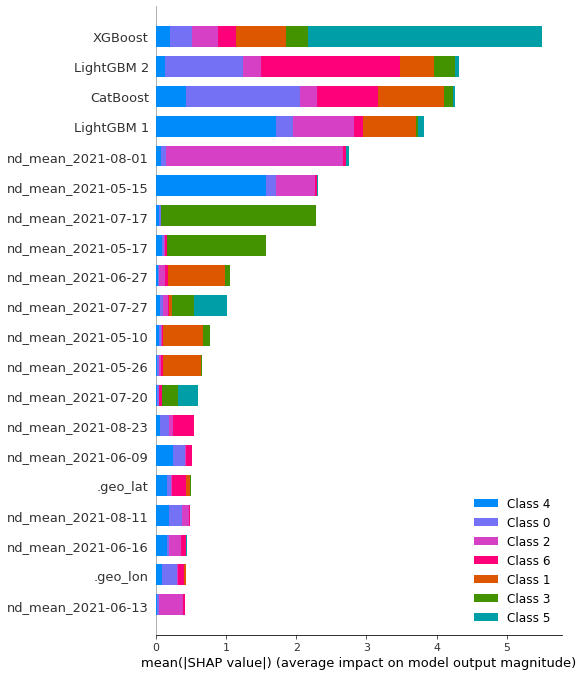

In [13]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X[FINAL_FEATURES])
shap.summary_plot(shap_values, X[FINAL_FEATURES], feature_names=FINAL_FEATURES)

In [14]:
feature_importance_df = pd.DataFrame(clf.feature_importances_, index=FINAL_FEATURES)
feature_importance_df.sort_values(by=0, ascending=False)

,0
CatBoost,850
LightGBM 1,831
nd_mean_2021-05-15,760
.geo_lon,616
XGBoost,567
nd_mean_2021-08-01,463
.geo_lat,458
LightGBM 2,454
nd_mean_2021-05-17,387
nd_mean_2021-06-16,348
